<a href="https://colab.research.google.com/github/Williantx/exercicio-1/blob/main/Previs%C3%A3o_de_Tend%C3%AAncia_do_IBOVESPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tech Challenge - Fase 2**

Você foi recentemente alocado em uma equipe de cientistas de dados de
um grande fundo de investimentos brasileiro. Sua missão inicial é desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice.

Esse modelo será usado como insumo para alimentar dashboards internos de tomada de decisão dos analistas quantitativos da empresa.

**Dados**

Utilize os dados históricos do índice IBOVESPA, disponíveis
publicamente: https://br.investing.com/indices/bovespa-historical-data

**Requisitos:**
*    Selecione o período “diário”.
*    Baixe um intervalo de pelo menos 2 anos de dados.
*    Realize o pré-processamento necessário para utilizar os dados no
modelo.

**Objetivo**

Criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual, ou seja:

*    Seu modelo deve prever a tendência (↑ ou ↓) com acuracidade mínima de 75% em um conjunto de teste.
*    O conjunto de testes deverá conter o último mês (30 dias) de dados disponíveis.

**Como funciona a pontuação?**

O Ibovespa é medido em pontos — que representam uma escala matemática, não dinheiro direto.

Quando falam: "O Ibovespa fechou a 130.000 pontos", significa que a carteira teórica de ações que compõe o índice está 1300 vezes mais valorizada do que quando o índice foi criado (em 1968, com base 100 pontos).

O movimento (alta ou queda) é percentual.

Exemplo: Se o Ibovespa sobe de 130.000 para 131.300 pontos, ele subiu +1%.



ATRIBUTOS DA BASE

Data → Data de negociação.

Último → Preço de fechamento do pregão.

Abertura → Preço de abertura do pregão.

Máxima → Maior preço no pregão.

Mínima → Menor preço no pregão.

Vol. → Volume financeiro ou número de negócios (depende da fonte).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


In [ ]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet

In [ ]:
# Importar dados da base do Ibovespa - DataFrane de treinamento
df = pd.read_csv('/content/drive/MyDrive/POSTECH -TECH_CHALLENGE📚DATA_ANALYTCS/Dados Históricos - Ibovespa.csv', parse_dates=['Data'])

/tmp/ipython-input-3703067073.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('/content/drive/MyDrive/POSTECH -TECH_CHALLENGE📚DATA_ANALYTCS/Dados Históricos - Ibovespa.csv', parse_dates=['Data'])


In [ ]:
# Primeiras impressões no DataFrame
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2025-08-26,137.405,138.026,138.037,137.058,"4,08M","-0,45%"
1,2025-08-25,138.025,137.971,138.890,137.971,"5,99B","0,04%"
2,2025-08-22,137.968,134.511,138.072,134.511,"9,32B","2,57%"
3,2025-08-21,134.511,134.664,134.837,133.874,"6,52B","-0,12%"
4,2025-08-20,134.666,134.430,134.964,134.122,"6,85B","0,17%"


In [ ]:
# Verificar dados nulos na base
df.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,0
Var%,0


In [ ]:
# Verificar duplicados
df.duplicated().sum()

np.int64(0)

In [ ]:
# Verificar tamanho e detalhes do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      1285 non-null   datetime64[ns]
 1   Último    1285 non-null   float64       
 2   Abertura  1285 non-null   float64       
 3   Máxima    1285 non-null   float64       
 4   Mínima    1285 non-null   float64       
 5   Vol.      1285 non-null   object        
 6   Var%      1285 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 70.4+ KB


In [ ]:
# Estatística descritiva do DataFrame
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Data,1285,2023-01-28 17:24:25.214007808,2020-07-01 00:00:00,2021-10-15 00:00:00,2023-01-27 00:00:00,2024-05-15 00:00:00,2025-08-26 00:00:00,NaN
Último,1285.0,117.708719,93.58,109.069,117.841,127.128,141.264,11.085865
Abertura,1285.0,117.676219,93.586,109.036,117.806,127.129,141.265,11.089921
Máxima,1285.0,118.616851,95.34,110.21,118.695,127.824,141.564,10.97304
Mínima,1285.0,116.773685,93.387,108.18,116.791,126.223,140.597,11.184596


In [ ]:
# Converter variacao de porcentagem para decimal
df['Variacao'] = (((df['Último'] / df['Abertura']) -1) * 100).round(2)

df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values(by='Data', ignore_index=True)

df = df.drop(columns=['Var%'])

In [ ]:
display(df)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Variacao
0,2020-07-01,96.203,95.062,96.852,95.062,"10,16M",1.20
1,2020-07-02,96.235,96.206,97.864,96.052,"10,06M",0.03
2,2020-07-03,96.765,96.237,96.765,95.803,"5,35M",0.55
3,2020-07-06,98.937,96.776,99.257,96.768,"9,49M",2.23
4,2020-07-07,97.761,98.937,98.938,97.272,"8,95M",-1.19
...,...,...,...,...,...,...,...
1280,2025-08-20,134.666,134.430,134.964,134.122,"6,85B",0.18
1281,2025-08-21,134.511,134.664,134.837,133.874,"6,52B",-0.11
1282,2025-08-22,137.968,134.511,138.072,134.511,"9,32B",2.57
1283,2025-08-25,138.025,137.971,138.890,137.971,"5,99B",0.04


<Axes: >

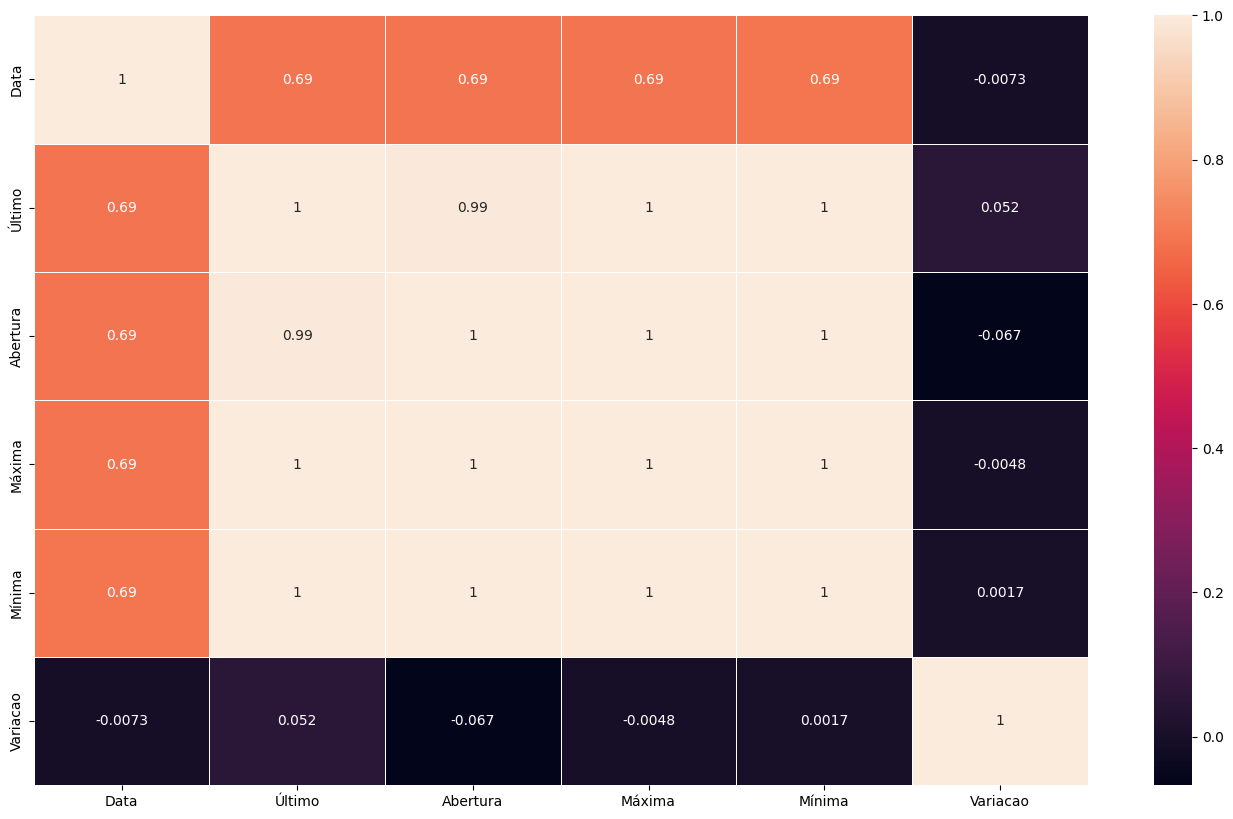

In [ ]:
# Variável Target (Resposta) - Tendencia
# Comportamento dos dados boxplot
# Correlação de Pearson

# Remover coluna Vol. pelo formato string
df = df.drop(columns='Vol.')

# Correlacionar colunas do DataFrame
correlacao_matriz = df.corr()

# Plotar gráfico heatmap com resultado da correlação
fig, ax = plt.subplots(figsize=(17,10))

sb.heatmap(data=correlacao_matriz, annot=True, linewidths=.5, ax=ax)

In [ ]:
# Ajustar os dias de final de semana/feriados de acordo com o último dia útil
df = df.set_index('Data')
df = df.asfreq('D')
df.reset_index(inplace=True)

# Preencher o restante das colunas com o último valor válido
for column in df.columns:
    if column != 'Data':
        df[column].fillna(method='ffill', inplace=True)

# Renomear como boas práticas - ds (datestamp) e y (variavel target)
df = df.rename(columns={'Data': 'ds', 'Último': 'y'})

# Criar a coluna unique_id
df['unique_id'] = 'IBOVESPA'

# Selecionar colunas que serão utilizadas posteriormente
df = df[['ds', 'y', 'unique_id']]

# Verificar o resultado
df.head(15)

/tmp/ipython-input-1356927966.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(method='ffill', inplace=True)
/tmp/ipython-input-1356927966.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='ffill', inplace=True)


,ds,y,unique_id
0,2020-07-01,96.203,IBOVESPA
1,2020-07-02,96.235,IBOVESPA
2,2020-07-03,96.765,IBOVESPA
3,2020-07-04,96.765,IBOVESPA
4,2020-07-05,96.765,IBOVESPA
5,2020-07-06,98.937,IBOVESPA
6,2020-07-07,97.761,IBOVESPA
7,2020-07-08,99.770,IBOVESPA
8,2020-07-09,99.160,IBOVESPA
9,2020-07-10,100.032,IBOVESPA


In [ ]:
# Decomposição de Séries Temporais

# tendencia - direçao
# sazonalidade - recorrencia das oscilações
# residuo - o que sobra do sinal

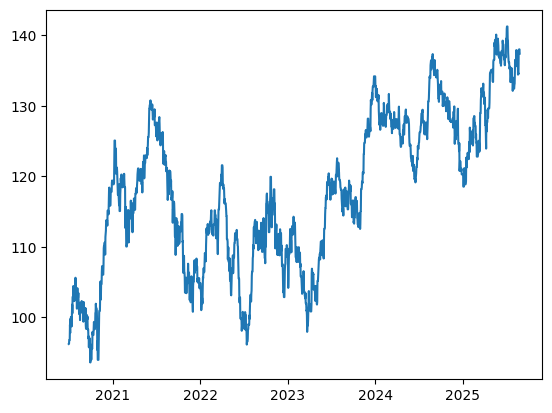

In [ ]:
# Avaliar a tendencia dos dados
df1 = df[['ds', 'y']]

# Definir a coluna ds como índice
df1 = df1.set_index('ds')

# Plotar gráfico
plt.plot(df1.index, df1.values)

Segunda parte

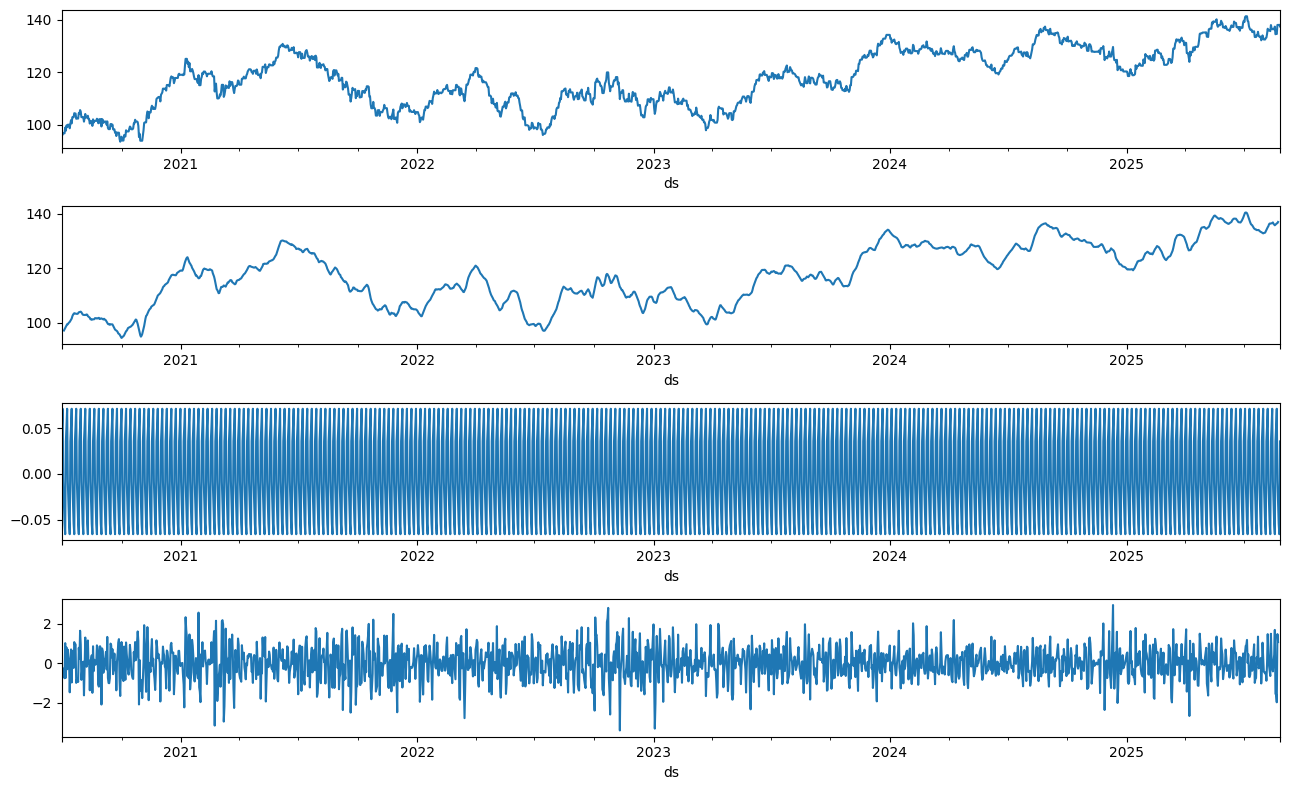

In [ ]:
# Decompor Séries Temporais
resultados = seasonal_decompose(df1)

# Plotar gráfico da decomposição
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13, 8))


resultados.observed.plot(ax=ax1) # Resultado Observado - Serie Temporal
resultados.trend.plot(ax=ax2) # Tendência
resultados.seasonal.plot(ax=ax3) # Sazonalidade - Oscilações
resultados.resid.plot(ax=ax4) # Resíduos

plt.tight_layout()

In [ ]:
# Série estacionária ou Série não-estacionária?

# Estacionária - Movimentação Constante / Não-Estacionária - Movimento não
# é constante

# Movimentação Constante: a média permanece a mesma de acordo com o tempo
# Movimentação Não Constante: Média está oscilando de acordo com o tempo

# Teste ADF - Augmented Dickey-Fuller - Método Científico

# H0 - hipótese nula (não é estacionária - possui dependência temporal)
# H1 - hipótese alternativa (rejeição da hipótese nula: é estacionária)

# P(value) - nível de significancia
# O mais comum é 0.05

# Se o valor for menor que o nível de significancia, rejeitamos a hipótese
# nula (não tem como acontecer)

# então, se p -value <= 0.05, então rejeitamos H0 com um nível de confiança
# de 95%

# Teste ADF
x = df1.y.values

resultado = adfuller(x)

print(f"Teste ADF")
print(f"Teste Estatístico: {resultado[0]}")
print(f"P-Value: {resultado[1]}")
print(f"Valores Críticos:")

for key, value in resultado[4].items():
  print(f"\t {key}: {value}")

# Rejeitamos a hipótese nula (H0) com um alto nível de confiança.
# A hipótese nula (H0) afirma que a série temporal não é estacionária.
# Portanto, ao rejeitar a H0, concluímos que a série temporal da variação
# diária do Ibovespa É ESTACIONÁRIA.

# Uma série temporal estacionária é aquela cujas propriedades estatísticas
# (média, variância, autocorrelação) não mudam ao longo do tempo. Isso é
# importante para muitos modelos de séries temporais, pois eles assumem
# estacionariedade.

Teste ADF
Teste Estatístico: -2.132877501829201
P-Value: 0.2315014896463356
Valores Críticos:
	 1%: -3.4338312580685653
	 5%: -2.863077778972339
	 10%: -2.5675886567541726


Transformação da Série Não-Estacionária em Estacionária

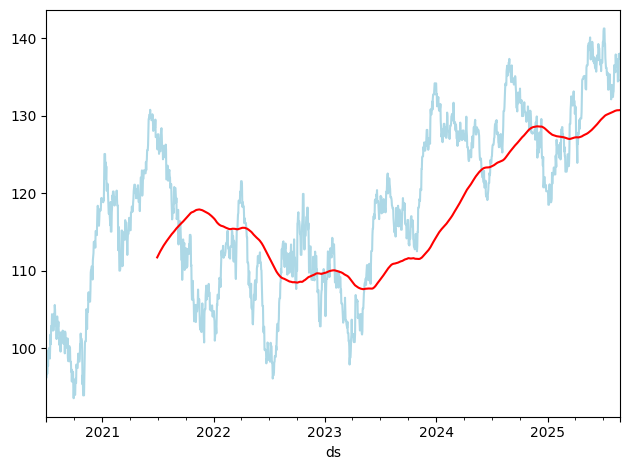

In [ ]:
# Definição da média móvel
# A média móvel pode ser usada como uma variável preditora em modelos
# de séries temporais.

# Média móvel
df1_mov = df1.rolling(365).mean().dropna()

# Criar o gráfico do resultado
f, ax = plt.subplots()
df1.plot(ax=ax, legend=False, color='lightblue')
df1_mov.plot(ax=ax, legend=False, color='red')
plt.tight_layout()

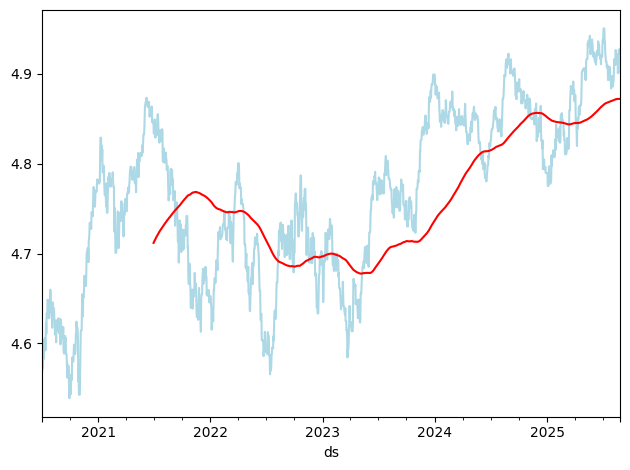

In [ ]:
# Aplicar o log para estabilizar a variancia da série temporal
df1_log = np.log(df1)

# Média móvel
df1_log_mov = df1_log.rolling(365).mean().dropna()

# Criar o gráfico do resultado
f, ax = plt.subplots()
df1_log.plot(ax=ax, legend=False, color='lightblue')
df1_log_mov.plot(ax=ax, legend=False, color='red')
plt.tight_layout()

In [ ]:
# Teste ADF
y_mov = df1_log.y.values

resultado = adfuller(y_mov)

print(f"Teste ADF")
print(f"Teste Estatístico: {resultado[0]}")
print(f"P-Value: {resultado[1]}")
print(f"Valores Críticos:")

for key, value in resultado[4].items():
  print(f"\t {key}: {value}")

Teste ADF
Teste Estatístico: -2.2849527896091644
P-Value: 0.17686693027612982
Valores Críticos:
	 1%: -3.4338312580685653
	 5%: -2.863077778972339
	 10%: -2.5675886567541726


<Axes: xlabel='ds'>

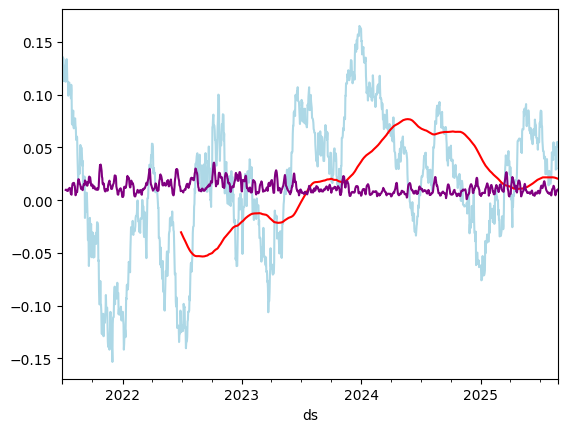

In [ ]:
# Subtrair a média móvel do log aplicado
df1s = (df1_log - df1_log_mov).dropna()

# Calcular média móvel
df1s_mov = df1s.rolling(365).mean() # Removed .mean() from the end

# Calcular o Desvio Padrão
df1s_std = df1s.rolling(12).std()

# Converter o índice para DatetimeIndex para o matplotlib
df1s.index = pd.to_datetime(df1s.index)
df1s_mov.index = pd.to_datetime(df1s_mov.index)
df1s_std.index = pd.to_datetime(df1s_std.index)

# Criar o gráfico
f, ax = plt.subplots()
df1s.plot(ax=ax, legend=False, color='lightblue')
df1s_mov.plot(ax=ax, legend=False, color='red')
df1s_std.plot(ax=ax, legend=False, color='purple')


In [ ]:
# Teste ADF
y_s = df1s.y.values

resultado = adfuller(y_s)

print(f"Teste ADF")
print(f"Teste Estatístico: {resultado[0]}")
print(f"P-Value: {resultado[1]}")
print(f"Valores Críticos:")

for key, value in resultado[4].items():
  print(f"\t {key}: {value}")

Teste ADF
Teste Estatístico: -3.0645639960075464
P-Value: 0.029289198764158447
Valores Críticos:
	 1%: -3.4346651465364264
	 5%: -2.863445867307207
	 10%: -2.567784657747782


<Axes: xlabel='ds'>

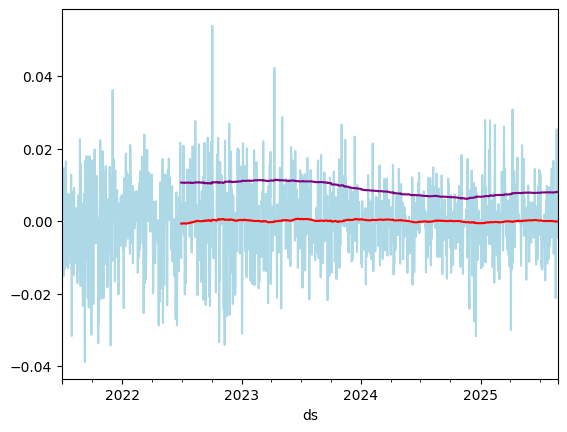

In [ ]:
# Aplicar a diferenciação/derivada para diminuir o p-value
df1_diff = df1s.diff()

# Média Móvel
df1_diff_mov = df1_diff.rolling(365).mean()

# Desvio Padrão
df1_diff_std = df1_diff.rolling(365).std()

# Criar o gráfico
f, ax = plt.subplots()
df1_diff.plot(ax=ax, legend=False, color='lightblue')
df1_diff_mov.plot(ax=ax, legend=False, color='red')
df1_diff_std.plot(ax=ax, legend=False, color='purple')

In [ ]:
# Teste ADF
y_d = df1_diff.y.dropna().values

resultado = adfuller(y_d)

print(f"Teste ADF")
print(f"Teste Estatístico: {resultado[0]}")
print(f"P-Value: {resultado[1]}")
print(f"Valores Críticos:")

for key, value in resultado[4].items():
  print(f"\t {key}: {value}")

Teste ADF
Teste Estatístico: -39.7257119870729
P-Value: 0.0
Valores Críticos:
	 1%: -3.434667995897907
	 5%: -2.863447124874016
	 10%: -2.5677853274099864


In [ ]:
# ACF / PACF

# lag
# a técnica de Rolling Window ajuda a realizar um cálculo (i.e. média)
# para cada janela de X dias consecutivos ao longo da série temporal

# ACF - Autocorrelação - relação direta e indireta
# como os pontos de dados em diferentes pontos no tempo estão
# linearmente relacionados entre si em função de sua diferença de tempo

# PACF - Autocorrelação parcial - somente relação direta
# é a correlação parcial desta série temporal com ela mesma nesse lag
# dadas as informações entre os dois tempos

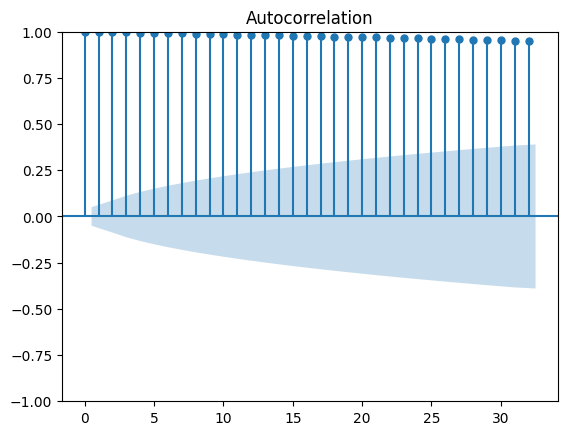

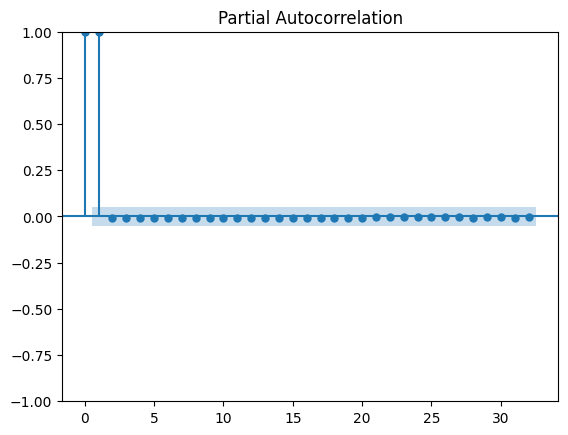

In [ ]:
# Plotar gráficos de ACF e PACF

plot_acf(df1_mov)
plot_pacf(df1_mov)
plt.show()

Terceira Parte

In [ ]:
# Criar base de treino
treino = df.iloc[:-30] # tudo até últimos 30 dias
print(f"Tamanho da minha base de treino é: {len(treino)}")

# Criar base de teste com últimos 30 dias
# quanto maior o tempo, maior a largura de banda (erro)
teste = df.iloc[-30:] # Últimos 30 dias
print(f"Tamanho da minha base de teste é: {len(teste)}")

Tamanho da minha base de treino é: 1853
Tamanho da minha base de teste é: 30


In [ ]:
# método de validação
# MAPE - Erro Percentual Médio
# WMAPE

def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

Modelo #1 - Naive (Baseline)

WMAPE do modelo Naive: 1.67%
MSE do modelo Naive: 7.05914486666666
RMSE do modelo Naive: 2.6569051294065167


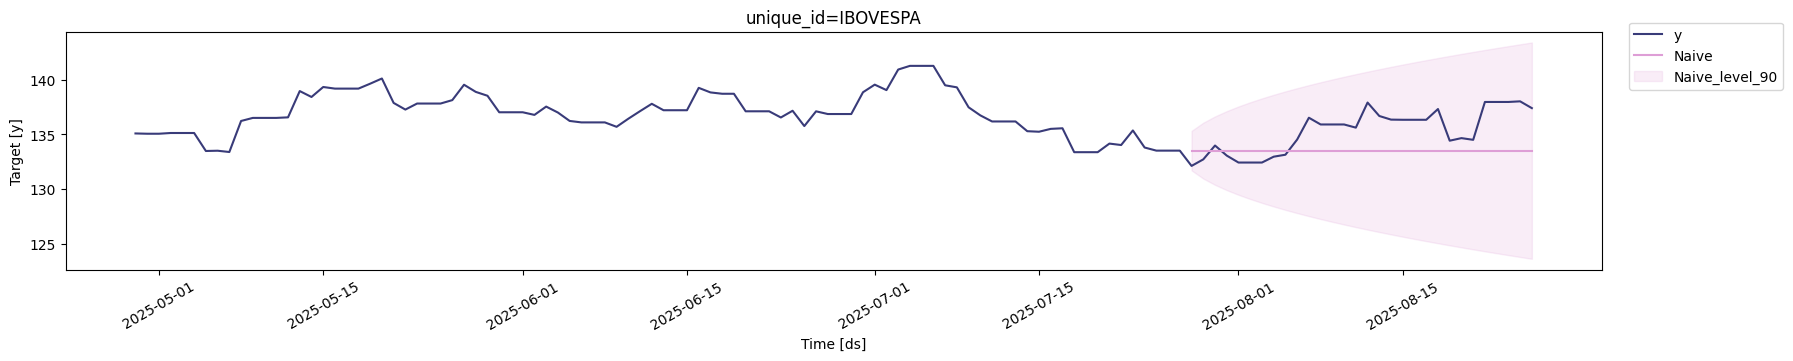

In [ ]:
# Criar modelo baseline (Solução trivial): prever o valor do último período conhecido
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)

# Treinar o modelo utilizando base de treino recém criada
model.fit(treino)

# Passar o número de passos à frente (tamanho do teste) para h
forecast_df = model.predict(h=len(teste), level=[90]) # 90% de precisão do modelo
forecast_df = forecast_df.reset_index().merge(teste, on=['ds', 'unique_id'], how='left')
forecast_df = forecast_df.drop(columns={'index'})

# Avaliar o modelo através de métricas de classificação
# WMAPE
wmape1 = wmape(forecast_df['y'], forecast_df['Naive'])

# MSE
mse1 = mean_squared_error(forecast_df['y'], forecast_df['Naive'])

# RMSE
rmse1 = np.sqrt(mse1)

print(f"WMAPE do modelo Naive: {wmape1:.2%}")
print(f"MSE do modelo Naive: {mse1}")
print(f"RMSE do modelo Naive: {rmse1}")

# Plotar gráfico do resultado
model.plot(treino, forecast_df, level=[90], unique_ids=['IBOVESPA'], engine='matplotlib', max_insample_length=90)

In [ ]:
forecast_df.head()

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,y
0,IBOVESPA,2025-07-28,133.524,131.721070,135.326930,132.129
1,IBOVESPA,2025-07-29,133.524,130.974271,136.073729,132.726
2,IBOVESPA,2025-07-30,133.524,130.401233,136.646767,133.990
3,IBOVESPA,2025-07-31,133.524,129.918139,137.129861,133.071
4,IBOVESPA,2025-08-01,133.524,129.492525,137.555475,132.437


Modelo #2 - SeasonalNaive (Baseline com Sazonalidade)

WMAPE do modelo Naive: 1.61%
MSE do modelo Naive: 6.333404966666661
RMSE do modelo Naive: 2.516625710483516


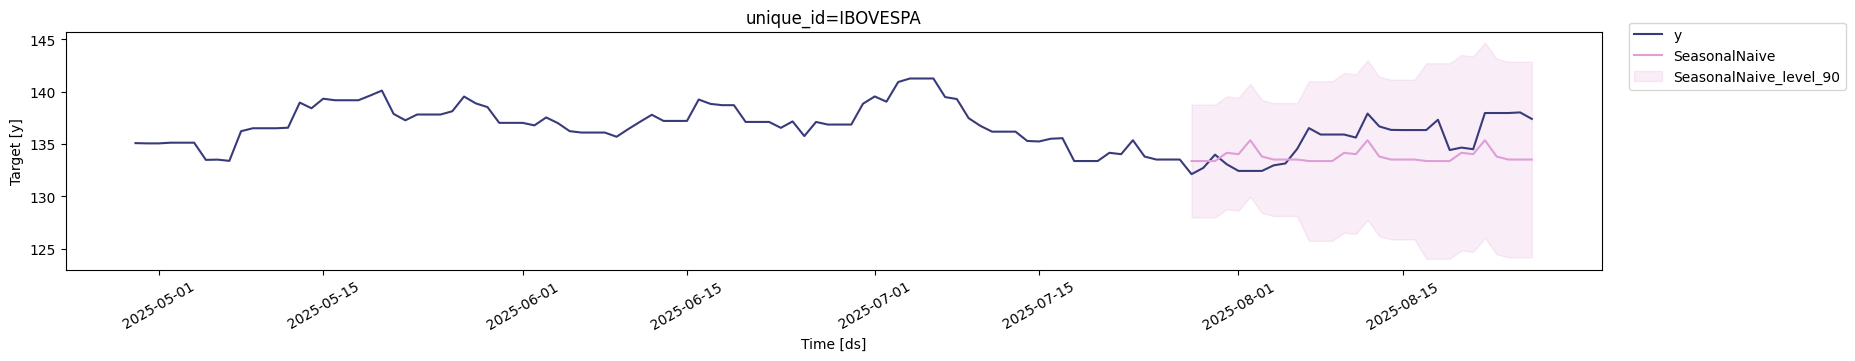

In [ ]:
# Criar modelo de baseline com sazonalidade
model_s = StatsForecast(models=[SeasonalNaive(season_length=10)], freq='D', n_jobs=-1)
# O Ibovespa tem ciclos de 5 e 10 dias muito claros.

# Treinar o modelo utilizando base de treino recém criada
model_s.fit(treino)

# Passar o número de passos à frente (tamanho do teste) para h
forecast_dfs = model_s.predict(h=len(teste), level=[90]) # 90% de precisão do modelo
forecast_dfs = forecast_dfs.reset_index().merge(teste, on=['ds', 'unique_id'], how='left')
forecast_dfs = forecast_dfs.drop(columns={'index'})

# Avaliar o modelo através de métricas de classificação
# WMAPE
wmape2 = wmape(forecast_dfs['y'], forecast_dfs['SeasonalNaive'])

# MSE
mse2 = mean_squared_error(forecast_dfs['y'], forecast_dfs['SeasonalNaive'])

# RMSE
rmse2 = np.sqrt(mse2)

print(f"WMAPE do modelo Naive: {wmape2:.2%}")
print(f"MSE do modelo Naive: {mse2}")
print(f"RMSE do modelo Naive: {rmse2}")

# Plotar gráfico do resultado
model.plot(treino, forecast_dfs, level=[90], unique_ids=['IBOVESPA'], engine='matplotlib', max_insample_length=90)

In [ ]:
forecast_dfs.head()

,unique_id,ds,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,y
0,IBOVESPA,2025-07-28,133.382,127.991641,138.772359,132.129
1,IBOVESPA,2025-07-29,133.382,127.991641,138.772359,132.726
2,IBOVESPA,2025-07-30,133.382,127.991641,138.772359,133.990
3,IBOVESPA,2025-07-31,134.167,128.776641,139.557359,133.071
4,IBOVESPA,2025-08-01,134.036,128.645641,139.426359,132.437


Modelo #3 - SeasonalWindowAverage (Sazonalidade e Média Móvel)

WMAPE do modelo Naive: 1.30%
MSE do modelo Naive: 4.434017366666671
RMSE do modelo Naive: 2.1057106559702525


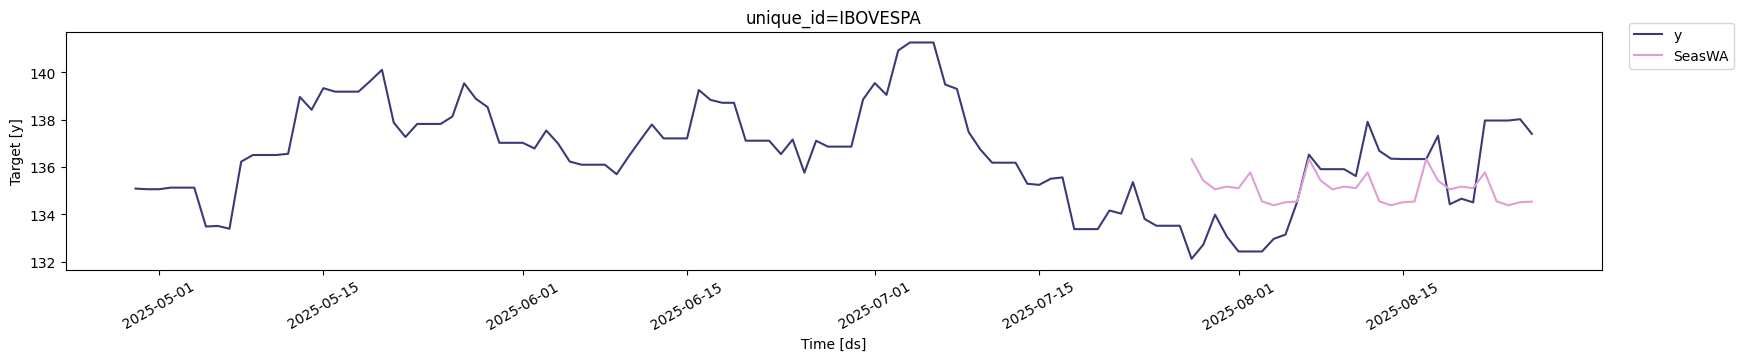

In [ ]:
# Criar modelo de baseline com sazonalidade e media movel
model_sm = StatsForecast(models=[SeasonalWindowAverage(season_length=10, window_size=2)], freq='D', n_jobs=-1)
# O Ibovespa tem ciclos de 5 e 10 dias (duas semanas) muito claros.

# Treinar o modelo utilizando base de treino recém criada
model_sm.fit(treino)

# Passar o número de passos à frente (tamanho do teste) para h
forecast_dfsm = model_sm.predict(h=len(teste))
forecast_dfsm = forecast_dfsm.reset_index().merge(teste, on=['ds', 'unique_id'], how='left')
forecast_dfsm = forecast_dfsm.drop(columns={'index'})

# Avaliar o modelo através de métricas de classificação
# WMAPE
wmape3 = wmape(forecast_dfsm['y'], forecast_dfsm['SeasWA'])

# MSE
mse3 = mean_squared_error(forecast_dfsm['y'], forecast_dfsm['SeasWA'])

# RMSE
rmse3 = np.sqrt(mse3)

print(f"WMAPE do modelo Naive: {wmape3:.2%}")
print(f"MSE do modelo Naive: {mse3}")
print(f"RMSE do modelo Naive: {rmse3}")

# Plotar gráfico do resultado
model_sm.plot(treino, forecast_dfsm, unique_ids=['IBOVESPA'], engine='matplotlib', max_insample_length=90)

In [ ]:
forecast_dfsm.head()

,unique_id,ds,SeasWA,y
0,IBOVESPA,2025-07-28,136.3425,132.129
1,IBOVESPA,2025-07-29,135.4315,132.726
2,IBOVESPA,2025-07-30,135.0625,133.990
3,IBOVESPA,2025-07-31,135.1770,133.071
4,IBOVESPA,2025-08-01,135.1115,132.437


Modelo #4 - ARIMA

WMAPE do modelo Naive: 1.67%
MSE do modelo Naive: 7.055406191743924
RMSE do modelo Naive: 2.6562014591788636


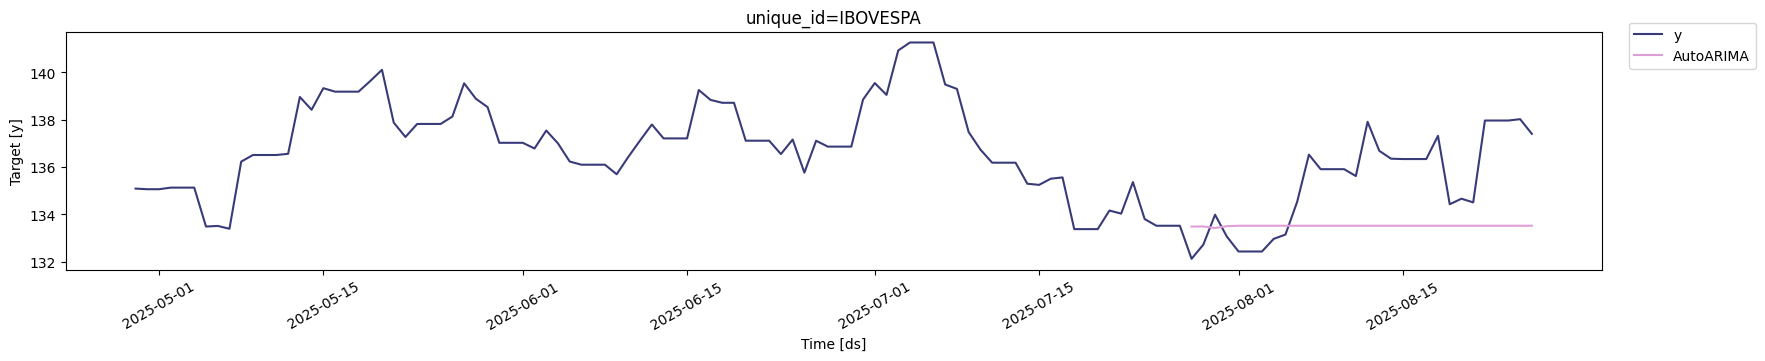

In [ ]:
# ARIMA
# (AR) Auto Regressive: olha para as vendas do passado e acha uma correlaçao futura
# (I) Integrated: quantidade que a série foi diferenciada
# (MA) Moving Average: Média móvel

# Criar modelo autoregressivo, integrado com média móvel
model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
# -1 = utilizar todas as CPUs disponíveis

# Treinar o modelo utilizando base de treino recém criada
model_a.fit(treino)

# Passar o número de passos à frente (tamanho do teste) para h
forecast_dfa = model_a.predict(h=len(teste), level=[90]) # 90% de precisão do modelo
forecast_dfa = forecast_dfa.reset_index().merge(teste, on=['ds', 'unique_id'], how='left')
forecast_dfa = forecast_dfa.drop(columns={'index'})

# Avaliar o modelo através de métricas de classificação
# WMAPE
wmape4 = wmape(forecast_dfa['y'], forecast_dfa['AutoARIMA'])

# MSE
mse4 = mean_squared_error(forecast_dfa['y'], forecast_dfa['AutoARIMA'])

# RMSE
rmse4 = np.sqrt(mse4)

print(f"WMAPE do modelo Naive: {wmape4:.2%}")
print(f"MSE do modelo Naive: {mse4}")
print(f"RMSE do modelo Naive: {rmse4}")

# Plotar gráfico do resultado
model_sm.plot(treino, forecast_dfa, unique_ids=['IBOVESPA'], engine='matplotlib', max_insample_length=90)

In [ ]:
forecast_dfa.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y
0,IBOVESPA,2025-07-28,133.487807,131.688118,135.287495,132.129
1,IBOVESPA,2025-07-29,133.494382,131.008343,135.980421,132.726
2,IBOVESPA,2025-07-30,133.428497,130.408248,136.448747,133.990
3,IBOVESPA,2025-07-31,133.505124,130.031881,136.978367,133.071
4,IBOVESPA,2025-08-01,133.524423,129.650803,137.398043,132.437


Modelo #5 - Prophet

In [ ]:
m = Prophet()
m.fit(treino)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbr6tavuk/995y3rqm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbr6tavuk/ibimahbc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17941', 'data', 'file=/tmp/tmpbr6tavuk/995y3rqm.json', 'init=/tmp/tmpbr6tavuk/ibimahbc.json', 'output', 'file=/tmp/tmpbr6tavuk/prophet_modelansp5t5x/prophet_model-20251018222122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:21:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:21:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
1878,2025-08-22
1879,2025-08-23
1880,2025-08-24
1881,2025-08-25
1882,2025-08-26


In [ ]:
forecast = m.predict(future)
forecast = forecast.reset_index().merge(teste, on=['ds'], how='left')
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1878,2025-08-22,139.645699,135.125178,144.286664
1879,2025-08-23,139.640162,135.425439,144.243191
1880,2025-08-24,139.623851,135.544480,144.320522
1881,2025-08-25,139.618896,135.097555,143.887430
1882,2025-08-26,139.701048,134.772736,144.856536


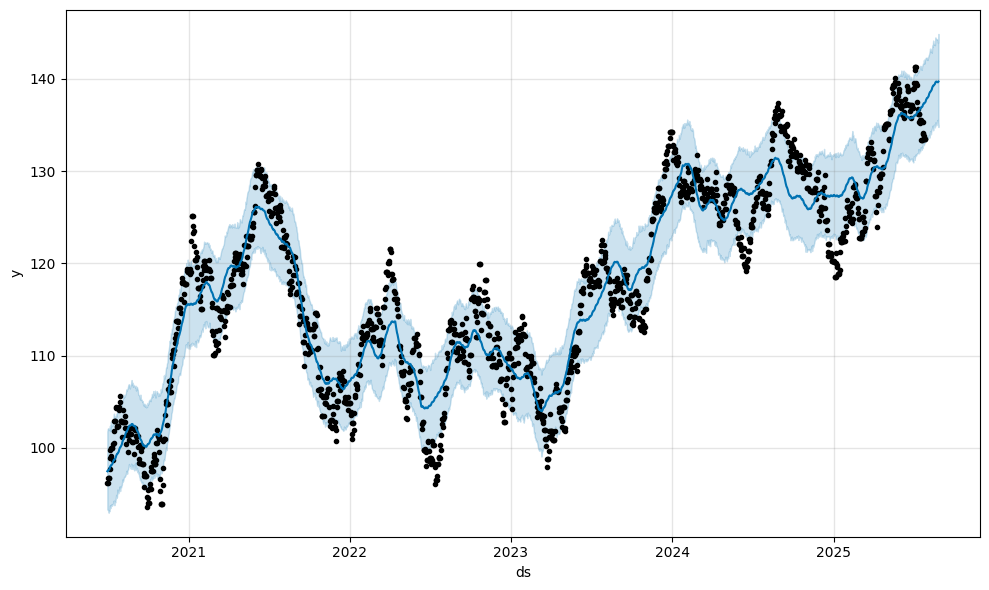

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
forecast.head()

,index,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,unique_id
0,0,2020-07-01,95.133817,93.321179,101.793769,95.133817,95.133817,2.335466,2.335466,2.335466,...,0.053282,2.282184,2.282184,2.282184,0.0,0.0,0.0,97.469283,NaN,NaN
1,1,2020-07-02,95.181048,93.292949,102.070179,95.181048,95.181048,2.373557,2.373557,2.373557,...,0.070245,2.303312,2.303312,2.303312,0.0,0.0,0.0,97.554605,NaN,NaN
2,2,2020-07-03,95.228279,93.210191,102.137826,95.228279,95.228279,2.311336,2.311336,2.311336,...,-0.016767,2.328103,2.328103,2.328103,0.0,0.0,0.0,97.539615,NaN,NaN
3,3,2020-07-04,95.275510,92.972127,102.089161,95.275510,95.275510,2.317335,2.317335,2.317335,...,-0.038765,2.356100,2.356100,2.356100,0.0,0.0,0.0,97.592845,NaN,NaN
4,4,2020-07-05,95.322741,93.199386,101.924150,95.322741,95.322741,2.327407,2.327407,2.327407,...,-0.059442,2.386849,2.386849,2.386849,0.0,0.0,0.0,97.650148,NaN,NaN


In [ ]:
# Remover Nan do resultado
forecast = forecast.dropna()

# Avaliar o modelo através de métricas de classificação
# wMAPE
wmape5 = wmape(forecast['y'].values, forecast['yhat'].values)

# MSE
mse5 = mean_squared_error(forecast['y'], forecast['yhat'])

# RMSE
rmse5 = np.sqrt(mse5)

print(f"WMAPE do modelo Naive: {wmape5:.2%}")
print(f"MSE do modelo Naive: {mse5}")
print(f"RMSE do modelo Naive: {rmse5}")

WMAPE do modelo Naive: 2.59%
MSE do modelo Naive: 14.412228507854506
RMSE do modelo Naive: 3.7963440976621845


In [ ]:
# Retornar Métricas de Classificação Consolidadas
print(f"WMAPE Naive: {wmape1:.2%}")
print(f"MSE Naive: {mse1}")
print(f"RMSE Naive: {rmse1}")
print('----------------------------')
print(f"WMAPE SeasonalNaive: {wmape2:.2%}")
print(f"MSE SeasonalNaive: {mse2}")
print(f"RMSE SeasonalNaive: {rmse2}")
print('----------------------------')
print(f"WMAPE SeasonalWindowAverage: {wmape3:.2%}")
print(f"MSE SeasonalWindowAverage: {mse3}")
print(f"RMSE SeasonalWindowAverage: {rmse3}")
print('----------------------------')
print(f"WMAPE ARIMA: {wmape4:.2%}")
print(f"MSE ARIMA: {mse4}")
print(f"RMSE ARIMA: {rmse4}")
print('----------------------------')
print(f"WMAPE Prophet: {wmape5:.2%}")
print(f"MSE Prophet: {mse5}")
print(f"RMSE Prophet: {rmse5}")

WMAPE Naive: 1.67%
MSE Naive: 7.05914486666666
RMSE Naive: 2.6569051294065167
----------------------------
WMAPE SeasonalNaive: 1.61%
MSE SeasonalNaive: 6.333404966666661
RMSE SeasonalNaive: 2.516625710483516
----------------------------
WMAPE SeasonalWindowAverage: 1.30%
MSE SeasonalWindowAverage: 4.434017366666671
RMSE SeasonalWindowAverage: 2.1057106559702525
----------------------------
WMAPE ARIMA: 1.67%
MSE ARIMA: 7.055406191743924
RMSE ARIMA: 2.6562014591788636
----------------------------
WMAPE Prophet: 2.59%
MSE Prophet: 14.412228507854506
RMSE Prophet: 3.7963440976621845
